# 3D Convolutional Neural Network for Tomographic Alignment

## Expanding the Network: ResNet

Since based on previous analysis it is likely that the network was too small to properly identify the features necessary for alignment, the next logical step is to expand the network. Making deeper neural networks usually results in diminishing returns, but residual neural networks have proven to successfully allow for deeper neural networks. Now this model structure will be used in order to find some form of convergence.

In [1]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))
!pwd

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True
/home/liam/Projects/Tomographic Alignment


In [3]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 250
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data) 

In [4]:
# Checking shape of training and testing splits
trainset, testset = np.split(data, [int(entries * 4 / 5)])
print("Shape of Training Dataset: {}".format(trainset.shape))
print("Shape of Testing Dataset: {}".format(testset.shape))

(200, 2)
(50, 2)


In [5]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

# Get inplanes for resnet
def get_inplanes():
    return [64, 128, 256, 512]


# Preset for a 3x3x3 kernel convolution
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


# Preset for a 1x1x1 kernel convolution
def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

# Basic block for resnet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
# Bottleneck block for resnet
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    

# Resnet structure
class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=360):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    # make layer helper function
    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Generates form of resnet
def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [6]:
model = generate_model(50)
summary(model, (1, 1, 180, 128, 184))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 360]                  --
├─Conv3d: 1-1                            [1, 64, 180, 64, 92]      21,952
├─BatchNorm3d: 1-2                       [1, 64, 180, 64, 92]      128
├─ReLU: 1-3                              [1, 64, 180, 64, 92]      --
├─MaxPool3d: 1-4                         [1, 64, 90, 32, 46]       --
├─Sequential: 1-5                        [1, 256, 90, 32, 46]      --
│    └─Bottleneck: 2-1                   [1, 256, 90, 32, 46]      --
│    │    └─Conv3d: 3-1                  [1, 64, 90, 32, 46]       4,096
│    │    └─BatchNorm3d: 3-2             [1, 64, 90, 32, 46]       128
│    │    └─ReLU: 3-3                    [1, 64, 90, 32, 46]       --
│    │    └─Conv3d: 3-4                  [1, 64, 90, 32, 46]       110,592
│    │    └─BatchNorm3d: 3-5             [1, 64, 90, 32, 46]       128
│    │    └─ReLU: 3-6                    [1, 64, 90, 32, 46]       --


In [7]:
# Train the model

# Create writer and profiler to analyze loss over each epoch
writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = generate_model(50)
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 5e-2, momentum=0.9, weight_decay = 0)
criterion = nn.MSELoss(reduction = 'mean')
criterion.to(device)
num_epochs = 500

# Iniitializing variables to show statistics
iteration = 0
test_iteration = 0
loss_list = []
test_loss_list = []
epoch_loss_averages = []
test_epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    
    epoch_loss = 0
    test_epoch_loss = 0
    
    for i, data in enumerate(trainset, 0):
        
        inputs, truths = norm(torch.from_numpy(data[0]).to(device)), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Epoch: {}   Training Loss: {} '.format(epoch, epoch_loss / trainset.shape[0]))
            
    for i, test_data in enumerate(testset, 0):
        
        inputs, truths = norm(torch.from_numpy(test_data[0]).to(device)), torch.from_numpy(test_data[1]).to(device).float()
        outputs = net(inputs).to(device)
        test_loss = criterion(outputs, truths)
        
        writer.add_scalar("Loss / Test", test_loss, epoch) # adds testing loss scalar
        test_loss_list.append(test_loss.cpu().detach().numpy())
        test_epoch_loss += test_loss.cpu().detach().numpy()
        
        test_iteration +=1
        if test_iteration % testset.shape[0] == 0:
            test_epoch_loss_averages.append(test_epoch_loss / testset.shape[0])
            print('Epoch: {}   Validation Loss: {} '.format(epoch, test_epoch_loss / testset.shape[0]))
            
writer.flush()
writer.close()

Device: cuda:0
Epoch: 0   Training Loss: 8.957998476028443 
Epoch: 0   Validation Loss: 8.729180088043213 
Epoch: 1   Training Loss: 8.560987219810485 
Epoch: 1   Validation Loss: 8.730897922515869 
Epoch: 2   Training Loss: 8.550113348960876 
Epoch: 2   Validation Loss: 8.730431394577026 
Epoch: 3   Training Loss: 8.54323893070221 
Epoch: 3   Validation Loss: 8.728847045898437 
Epoch: 4   Training Loss: 8.538480360507965 
Epoch: 4   Validation Loss: 8.729038133621216 
Epoch: 5   Training Loss: 8.535368063449859 
Epoch: 5   Validation Loss: 8.729434862136841 
Epoch: 6   Training Loss: 8.533001775741576 
Epoch: 6   Validation Loss: 8.728774299621582 
Epoch: 7   Training Loss: 8.5313955950737 
Epoch: 7   Validation Loss: 8.729530897140503 
Epoch: 8   Training Loss: 8.529573242664338 
Epoch: 8   Validation Loss: 8.732399024963378 
Epoch: 9   Training Loss: 8.528328182697296 
Epoch: 9   Validation Loss: 8.733541069030762 
Epoch: 10   Training Loss: 8.527204298973084 
Epoch: 10   Validation

Epoch: 88   Training Loss: 8.518852310180664 
Epoch: 88   Validation Loss: 8.762762145996094 
Epoch: 89   Training Loss: 8.517657721042633 
Epoch: 89   Validation Loss: 8.812623338699341 
Epoch: 90   Training Loss: 8.51192364692688 
Epoch: 90   Validation Loss: 8.781731624603271 
Epoch: 91   Training Loss: 8.515073494911194 
Epoch: 91   Validation Loss: 8.75806261062622 
Epoch: 92   Training Loss: 8.514507660865783 
Epoch: 92   Validation Loss: 8.739186315536498 
Epoch: 93   Training Loss: 8.507986145019531 
Epoch: 93   Validation Loss: 8.742564096450806 
Epoch: 94   Training Loss: 8.502804119586944 
Epoch: 94   Validation Loss: 8.746643810272216 
Epoch: 95   Training Loss: 8.528722047805786 
Epoch: 95   Validation Loss: 8.741390705108643 
Epoch: 96   Training Loss: 8.526337175369262 
Epoch: 96   Validation Loss: 8.739459505081177 
Epoch: 97   Training Loss: 8.525459563732147 
Epoch: 97   Validation Loss: 8.73846200942993 
Epoch: 98   Training Loss: 8.525029764175414 
Epoch: 98   Valid

Epoch: 174   Training Loss: 8.400233187675475 
Epoch: 174   Validation Loss: 8.970139093399048 
Epoch: 175   Training Loss: 8.444866392612457 
Epoch: 175   Validation Loss: 8.73148271560669 
Epoch: 176   Training Loss: 8.395065395832061 
Epoch: 176   Validation Loss: 8.74410969734192 
Epoch: 177   Training Loss: 8.362063026428222 
Epoch: 177   Validation Loss: 8.834840488433837 
Epoch: 178   Training Loss: 8.349809274673461 
Epoch: 178   Validation Loss: 8.889199390411378 
Epoch: 179   Training Loss: 8.409840941429138 
Epoch: 179   Validation Loss: 8.761331434249877 
Epoch: 180   Training Loss: 8.368677399158479 
Epoch: 180   Validation Loss: 8.752004528045655 
Epoch: 181   Training Loss: 8.380444598197936 
Epoch: 181   Validation Loss: 8.76066551208496 
Epoch: 182   Training Loss: 8.367452325820922 
Epoch: 182   Validation Loss: 8.762312755584716 
Epoch: 183   Training Loss: 8.396696443557738 
Epoch: 183   Validation Loss: 8.750476322174073 
Epoch: 184   Training Loss: 8.3757190084457

Epoch: 259   Validation Loss: 11.187138996124268 
Epoch: 260   Training Loss: 3.82930949896574 
Epoch: 260   Validation Loss: 11.166379184722901 
Epoch: 261   Training Loss: 3.7375104987621306 
Epoch: 261   Validation Loss: 11.748219966888428 
Epoch: 262   Training Loss: 3.6087640383839608 
Epoch: 262   Validation Loss: 11.2523193359375 
Epoch: 263   Training Loss: 3.527877807021141 
Epoch: 263   Validation Loss: 11.556866264343261 
Epoch: 264   Training Loss: 3.5178425076603888 
Epoch: 264   Validation Loss: 11.055824699401855 
Epoch: 265   Training Loss: 3.3146920186281204 
Epoch: 265   Validation Loss: 11.108867683410644 
Epoch: 266   Training Loss: 3.3114848208427428 
Epoch: 266   Validation Loss: 11.104947948455811 
Epoch: 267   Training Loss: 3.180539017021656 
Epoch: 267   Validation Loss: 11.220477962493897 
Epoch: 268   Training Loss: 3.1332901403307916 
Epoch: 268   Validation Loss: 11.272349033355713 
Epoch: 269   Training Loss: 3.1356643545627594 
Epoch: 269   Validation Lo

Epoch: 343   Training Loss: 0.008945165360346436 
Epoch: 343   Validation Loss: 10.171838893890381 
Epoch: 344   Training Loss: 0.00850167522439733 
Epoch: 344   Validation Loss: 10.127960500717164 
Epoch: 345   Training Loss: 0.008147875455906615 
Epoch: 345   Validation Loss: 10.120022201538086 
Epoch: 346   Training Loss: 0.007874271019827574 
Epoch: 346   Validation Loss: 10.157535257339477 
Epoch: 347   Training Loss: 0.007699846664909273 
Epoch: 347   Validation Loss: 10.182871627807618 
Epoch: 348   Training Loss: 0.007558171334676444 
Epoch: 348   Validation Loss: 10.178248739242553 
Epoch: 349   Training Loss: 0.007409696804825216 
Epoch: 349   Validation Loss: 10.179117889404298 
Epoch: 350   Training Loss: 0.007095775061752647 
Epoch: 350   Validation Loss: 10.191899824142457 
Epoch: 351   Training Loss: 0.006872721253894269 
Epoch: 351   Validation Loss: 10.191537446975708 
Epoch: 352   Training Loss: 0.006555251419777051 
Epoch: 352   Validation Loss: 10.18891531944275 
Ep

Epoch: 425   Training Loss: 0.0013199717753741424 
Epoch: 425   Validation Loss: 10.127834997177125 
Epoch: 426   Training Loss: 0.00124004447759944 
Epoch: 426   Validation Loss: 10.14943468093872 
Epoch: 427   Training Loss: 0.0012473101733485236 
Epoch: 427   Validation Loss: 10.144086542129516 
Epoch: 428   Training Loss: 0.001176311836898094 
Epoch: 428   Validation Loss: 10.127087116241455 
Epoch: 429   Training Loss: 0.0011495380089036188 
Epoch: 429   Validation Loss: 10.13703706741333 
Epoch: 430   Training Loss: 0.0010924875052296557 
Epoch: 430   Validation Loss: 10.153867263793945 
Epoch: 431   Training Loss: 0.0010838756502198521 
Epoch: 431   Validation Loss: 10.147155599594116 
Epoch: 432   Training Loss: 0.0010344377548608464 
Epoch: 432   Validation Loss: 10.133349552154542 
Epoch: 433   Training Loss: 0.001011367384053301 
Epoch: 433   Validation Loss: 10.142938947677612 
Epoch: 434   Training Loss: 0.0009734462577034719 
Epoch: 434   Validation Loss: 10.1566152954101

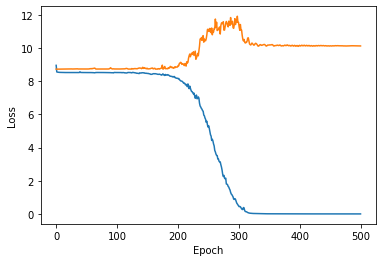

In [8]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.plot(test_epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

As we can see, a small dataset shows convergence which means this network MAY be able to be a solution. The next step is to test on a significantly larger dataset to see if this can deal with the overfitting problem. If the large set has convergence in the training data with a larger set then the overfitting must be dealt with in another way